In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#LIBRARIES

In [ ]:
import glob
import numpy as np
import torch
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50
import argparse
from torch.optim.lr_scheduler import StepLR
from torchvision.models.segmentation import deeplabv3_resnet101


# CONFIG

In [ ]:
ALL_CLASSES = ['background', 'flood']

LABEL_COLORS_LIST = [
    (0, 0, 0), # Background.
    (255, 255, 255), # Flood.
]

VIS_LABEL_MAP = [
    (0, 0, 0), # Background.
    (255, 0, 0), # Flood.
]

# UTILS

In [ ]:
plt.style.use('ggplot')

def set_class_values(all_classes, classes_to_train):
    """
    This (`class_values`) assigns a specific class label to the each of the classes.
    For example, `animal=0`, `archway=1`, and so on.

    :param all_classes: List containing all class names.
    :param classes_to_train: List containing class names to train.
    """
    class_values = [all_classes.index(cls.lower()) for cls in classes_to_train]
    return class_values

def get_label_mask(mask, class_values, label_colors_list):
    """
    This function encodes the pixels belonging to the same class
    in the image into the same label

    :param mask: NumPy array, segmentation mask.
    :param class_values: List containing class values, e.g car=0, bus=1.
    :param label_colors_list: List containing RGB color value for each class.
    """
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for value in class_values:
        for ii, label in enumerate(label_colors_list):
            if value == label_colors_list.index(label):
                label = np.array(label)
                label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = value
    label_mask = label_mask.astype(int)
    return label_mask

def draw_translucent_seg_maps(
    data,
    output,
    epoch,
    i,
    val_seg_dir,
    label_colors_list,
):
    """
    This function color codes the segmentation maps that are generated while
    validating. THIS IS NOT TO BE CALLED FOR SINGLE IMAGE TESTING
    """
    alpha = 1  # how much transparency
    beta = 0.6  # alpha + beta should be 1
    gamma = 0  # contrast

    seg_map = output[0]  # use only one output from the batch
    seg_map = torch.argmax(seg_map.squeeze(), dim=0).detach().cpu().numpy()

    image = data[0]
    image = np.array(image.cpu())
    image = np.transpose(image, (1, 2, 0))

    red_map = np.zeros_like(seg_map).astype(np.uint8)
    green_map = np.zeros_like(seg_map).astype(np.uint8)
    blue_map = np.zeros_like(seg_map).astype(np.uint8)

    for label_num in range(0, len(label_colors_list)):
        index = seg_map == label_num
        red_map[index] = label_colors_list[label_num][0]
        green_map[index] = label_colors_list[label_num][1]
        blue_map[index] = label_colors_list[label_num][2]

    rgb = np.stack([red_map, green_map, blue_map], axis=2)
    rgb = np.array(rgb, dtype=np.float32)
    # convert color to BGR format for OpenCV
    rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, rgb, beta, gamma, image)
    cv2.imwrite(f"{val_seg_dir}/e{epoch}_b{i}.jpg", image)


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model, out_dir, name='DeepLabV3_ResNet101'
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, os.path.join(out_dir, 'best_'+name+'.pth'))

def save_model(epochs, model, optimizer, criterion, out_dir, name='DeepLabV3_ResNet101'):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_dir, name+'.pth'))

def save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'DeepLabV3_ResNet101_accuracy.png'))

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'DeepLabV3_ResNet101_loss.png'))

# Define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image)
    return outputs

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()

    # create Numpy arrays containing zeros
    # later to be used to fill them with respective red, green, and blue pixels
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(VIS_LABEL_MAP)):
        index = labels == label_num
        red_map[index] = np.array(VIS_LABEL_MAP)[label_num, 0]
        green_map[index] = np.array(VIS_LABEL_MAP)[label_num, 1]
        blue_map[index] = np.array(VIS_LABEL_MAP)[label_num, 2]

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

def image_overlay(image, segmented_image):
    alpha = 1 # transparency for the original image
    beta = 1.0 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    return image

# DATASET

In [ ]:

def get_images(root_path):
    train_images = glob.glob(f"{root_path}/train_images/*")
    train_images.sort()
    train_masks = glob.glob(f"{root_path}/train_masks/*")
    train_masks.sort()
    valid_images = glob.glob(f"{root_path}/valid_images/*")
    valid_images.sort()
    valid_masks = glob.glob(f"{root_path}/valid_masks/*")
    valid_masks.sort()

    return train_images, train_masks, valid_images, valid_masks

def normalize():
    """
    Transform to normalize image.
    """
    transform = A.Compose([
        A.Normalize(
            mean=[0.45734706, 0.43338275, 0.40058118],
            std=[0.23965294, 0.23532275, 0.2398498],
            always_apply=True
        )
    ])
    return transform

def train_transforms(img_size):
    """
    Transforms/augmentations for training images and masks.

    :param img_size: Integer, for image resize.
    """
    train_image_transform = A.Compose([
        A.Resize(img_size, img_size, always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomSunFlare(p=0.2),
        A.RandomFog(p=0.2),
        A.ImageCompression(quality_lower=50, p=0.2),
    ],is_check_shapes=False)
    return train_image_transform

def valid_transforms(img_size):
    """
    Transforms/augmentations for validation images and masks.

    :param img_size: Integer, for image resize.
    """
    valid_image_transform = A.Compose([
        A.Resize(img_size, img_size, always_apply=True),
    ],is_check_shapes=False)
    return valid_image_transform

class SegmentationDataset(Dataset):
    def __init__(
        self,
        image_paths,
        mask_paths,
        tfms,
        norm_tfms,
        label_colors_list,
        classes_to_train,
        all_classes
    ):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.tfms = tfms
        self.norm_tfms = norm_tfms
        self.label_colors_list = label_colors_list
        self.all_classes = all_classes
        self.classes_to_train = classes_to_train
        # Convert string names to class values for masks.
        self.class_values = set_class_values(
            self.all_classes, self.classes_to_train
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_paths[index]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[index]).convert('RGB'))

        image = self.norm_tfms(image=image)['image']
        transformed = self.tfms(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Get colored label mask.
        mask = get_label_mask(mask, self.class_values, self.label_colors_list)

        image = np.transpose(image, (2, 0, 1))

        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

def get_dataset(
    train_image_paths,
    train_mask_paths,
    valid_image_paths,
    valid_mask_paths,
    all_classes,
    classes_to_train,
    label_colors_list,
    img_size
):
    train_tfms = train_transforms(img_size)
    valid_tfms = valid_transforms(img_size)
    norm_tfms = normalize()

    train_dataset = SegmentationDataset(
        train_image_paths,
        train_mask_paths,
        train_tfms,
        norm_tfms,
        label_colors_list,
        classes_to_train,
        all_classes
    )
    valid_dataset = SegmentationDataset(
        valid_image_paths,
        valid_mask_paths,
        valid_tfms,
        norm_tfms,
        label_colors_list,
        classes_to_train,
        all_classes
    )
    return train_dataset, valid_dataset

def get_data_loaders(train_dataset, valid_dataset, batch_size):
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, drop_last=True
    )
    valid_data_loader = DataLoader(
        valid_dataset, batch_size=batch_size, drop_last=True
    )

    return train_data_loader, valid_data_loader

# AUGMENTATIONS

/content/drive/MyDrive/flood-area-segmentation/train_images/10.jpg


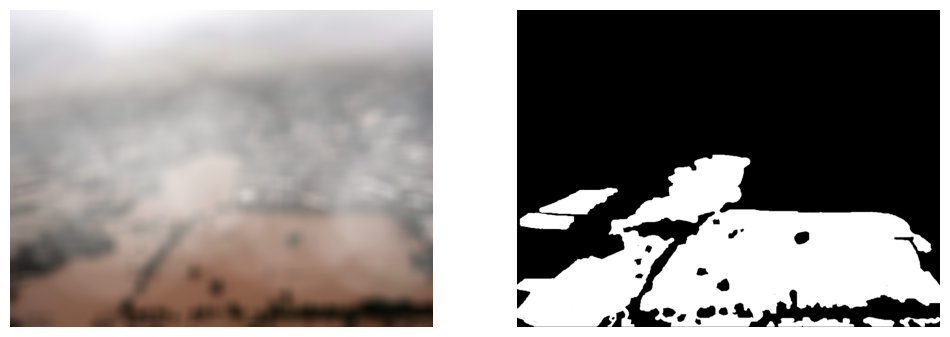

/content/drive/MyDrive/flood-area-segmentation/train_images/1000.jpg


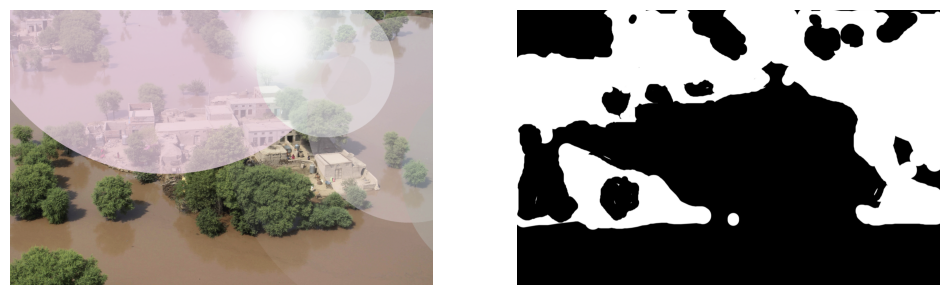

/content/drive/MyDrive/flood-area-segmentation/train_images/1001.jpg


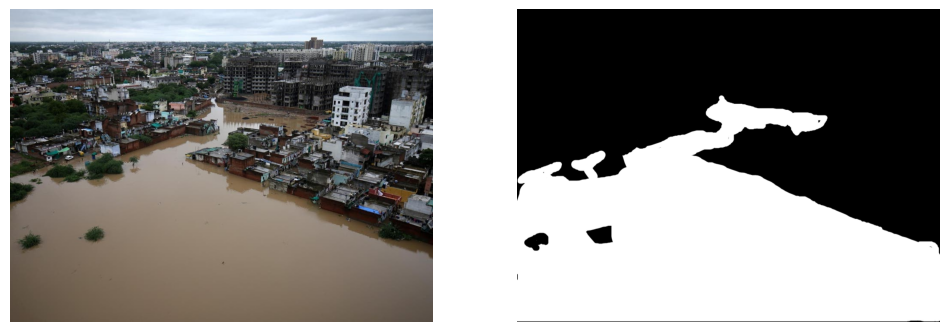

/content/drive/MyDrive/flood-area-segmentation/train_images/1002.jpg


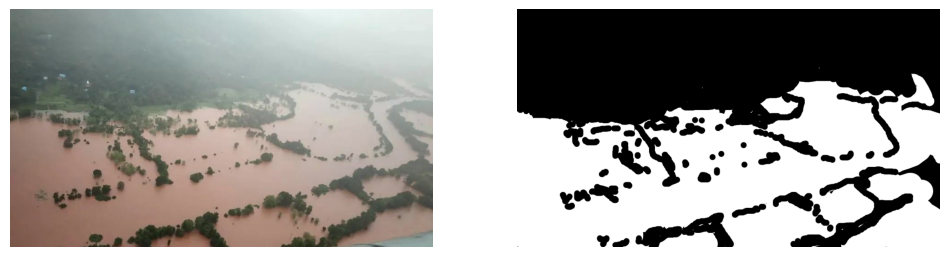

/content/drive/MyDrive/flood-area-segmentation/train_images/1003.jpg


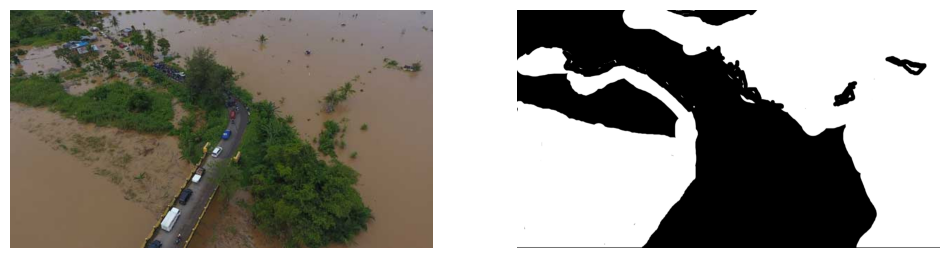

/content/drive/MyDrive/flood-area-segmentation/train_images/1004.jpg


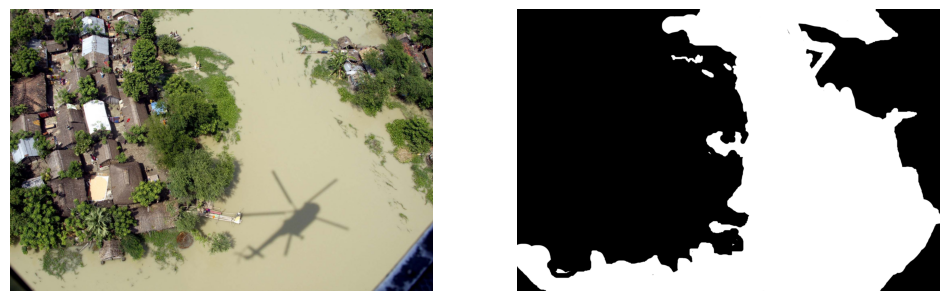

/content/drive/MyDrive/flood-area-segmentation/train_images/1007.jpg


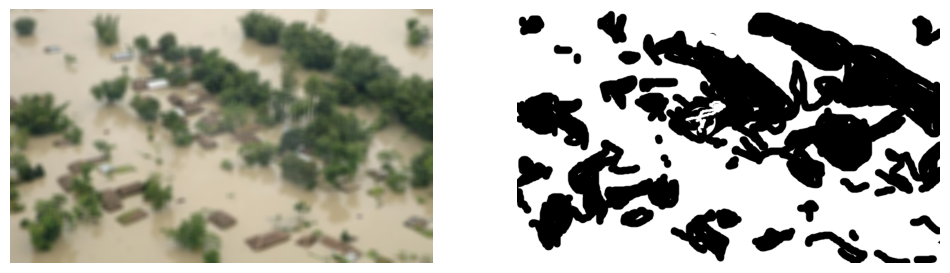

/content/drive/MyDrive/flood-area-segmentation/train_images/1008.jpg


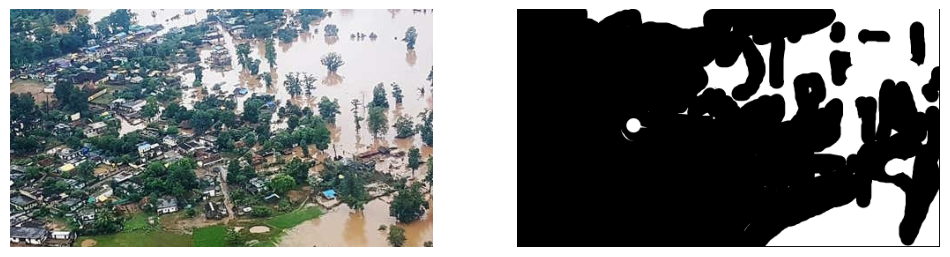

/content/drive/MyDrive/flood-area-segmentation/train_images/1009.jpg


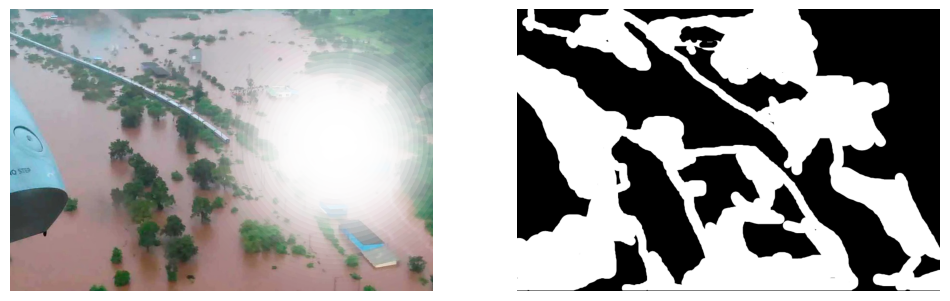

/content/drive/MyDrive/flood-area-segmentation/train_images/1010.jpg


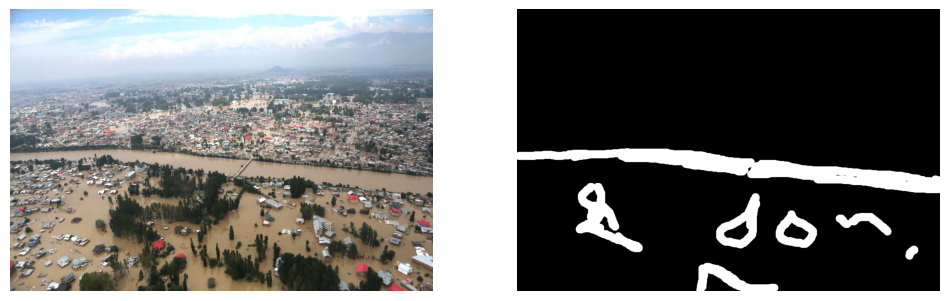

In [ ]:
train_images = glob.glob('/content/drive/MyDrive/flood-area-segmentation/train_images/*')
train_masks = glob.glob('/content/drive/MyDrive/flood-area-segmentation/train_masks/*')

train_images.sort()
train_masks.sort()


train_image_transform = A.Compose([
#     A.Resize(img_size, img_size, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomSunFlare(p=0.2),
    A.RandomFog(p=0.2),
    A.ImageCompression(quality_lower=50, p=0.2),
])


for i in range(10):
    print(train_images[i])
    image = np.array(Image.open(train_images[i]).convert('RGB'))
    mask = np.array(Image.open(train_masks[i]).convert('RGB'))

    transformed = train_image_transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']

    plt.figure(figsize=(12, 9))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

# METRICS

In [ ]:
def pix_acc(target, outputs, num_classes):
    """
    Calculates pixel accuracy, given target and output tensors
    and number of classes.
    """
    labeled = (target > 0) * (target <= num_classes)
    _, preds = torch.max(outputs.data, 1)
    correct = ((preds == target) * labeled).sum().item()
    return labeled, correct

# ENGINE

In [ ]:
def train(
    model,
    train_dataset,
    train_dataloader,
    device,
    optimizer,
    criterion,
    classes_to_train
):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct, train_running_label = 0, 0
    # Calculate the number of batches.
    num_batches = int(len(train_dataset)/train_dataloader.batch_size)
    prog_bar = tqdm(train_dataloader, total=num_batches, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    counter = 0 # to keep track of batch counter
    num_classes = len(classes_to_train)

    for i, data in enumerate(prog_bar):
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)['out']

        ##### BATCH-WISE LOSS #####
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        ###########################

        # For pixel accuracy.
        labeled, correct = pix_acc(target, outputs, num_classes)
        train_running_label += labeled.sum()
        train_running_correct += correct
        train_running_pixacc = 1.0 * correct / (np.spacing(1) + labeled.sum())
        #############################

        ##### BACKPROPAGATION AND PARAMETER UPDATION #####
        loss.backward()
        optimizer.step()
        ##################################################

        prog_bar.set_description(desc=f"Loss: {loss.detach().cpu().numpy():.4f} | PixAcc: {train_running_pixacc.cpu().numpy()*100:.2f}")

    ##### PER EPOCH LOSS #####
    train_loss = train_running_loss / counter
    ##########################

    ##### PER EPOCH METRICS ######
    # Pixel accuracy
    pixel_acc = ((1.0 * train_running_correct) / (np.spacing(1) + train_running_label)) * 100
    ##############################
    return train_loss, pixel_acc

def validate(
    model,
    valid_dataset,
    valid_dataloader,
    device,
    criterion,
    classes_to_train,
    label_colors_list,
    epoch,
    all_classes,
    save_dir
):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct, valid_running_label = 0, 0
    # Calculate the number of batches.
    num_batches = int(len(valid_dataset)/valid_dataloader.batch_size)
    num_classes = len(classes_to_train)

    with torch.no_grad():
        prog_bar = tqdm(valid_dataloader, total=num_batches, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
        counter = 0 # To keep track of batch counter.
        for i, data in enumerate(prog_bar):
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)['out']

            # Save the validation segmentation maps every
            # last batch of each epoch
            if i == num_batches - 1:
                draw_translucent_seg_maps(
                    data,
                    outputs,
                    epoch,
                    i,
                    save_dir,
                    label_colors_list,
                )

            ##### BATCH-WISE LOSS #####
            loss = criterion(outputs, target)
            valid_running_loss += loss.item()
            ###########################

            # For pixel accuracy.
            labeled, correct = pix_acc(target, outputs, num_classes)
            valid_running_label += labeled.sum()
            valid_running_correct += correct
            valid_running_pixacc = 1.0 * correct / (np.spacing(1) + labeled.sum())
            #############################

            prog_bar.set_description(desc=f"Loss: {loss.detach().cpu().numpy():.4f} | PixAcc: {valid_running_pixacc.cpu().numpy()*100:.2f}")

    ##### PER EPOCH LOSS #####
    valid_loss = valid_running_loss / counter
    ##########################

    ##### PER EPOCH METRICS ######
    # Pixel accuracy.
    pixel_acc = ((1.0 * valid_running_correct) / (np.spacing(1) + valid_running_label)) * 100.
    ##############################
    return valid_loss, pixel_acc

# MODEL

In [ ]:
"""
DeepLabV3 ResNet50 model.
"""
#def prepare_model(num_classes=2):
#    model = deeplabv3_resnet50(weights='DEFAULT')
#    model.classifier[4] = nn.Conv2d(256, num_classes, 1)
#    model.aux_classifier[4] = nn.Conv2d(256, num_classes, 1)
#    return model


"""
DeepLabV3 ResNet101 model.
"""

def prepare_model(num_classes=2):
    model = deeplabv3_resnet101(weights='DEFAULT')
    model.classifier[4] = nn.Conv2d(256, num_classes, 1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, 1)
    return model

# TRAIN

60,986,436 total parameters.
60,986,436 training parameters.
Adjusting learning rate of group 0 to 1.0000e-04.
EPOCH: 1
Training


Loss: 0.7512 | PixAcc: 98.34:   5%|▉                   | 3/64 [00:08<02:54,  2.86s/it]/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/functional.py:487: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(
Loss: 0.5055 | PixAcc: 67.38: 100%|████████████████████| 64/64 [03:12<00:00,  3.01s/it]


Validating


Loss: 0.2815 | PixAcc: 85.03: 100%|████████████████████| 8/8 [00:07<00:00,  1.04it/s]



Best validation loss: 0.32961568236351013

Saving best model for epoch: 1

Train Epoch Loss: 0.5100, Train Epoch PixAcc: 73.1827
Valid Epoch Loss: 0.3296, Valid Epoch PixAcc: 82.8793
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 2
Training


Loss: 0.3829 | PixAcc: 72.10: 100%|████████████████████| 64/64 [03:17<00:00,  3.09s/it]


Validating


Loss: 0.2717 | PixAcc: 90.34: 100%|████████████████████| 8/8 [00:07<00:00,  1.11it/s]


Train Epoch Loss: 0.3924, Train Epoch PixAcc: 74.0483
Valid Epoch Loss: 0.3309, Valid Epoch PixAcc: 89.4113
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 3
Training


Loss: 0.3399 | PixAcc: 78.76: 100%|████████████████████| 64/64 [03:18<00:00,  3.11s/it]


Validating


Loss: 0.2565 | PixAcc: 89.83: 100%|████████████████████| 8/8 [00:06<00:00,  1.15it/s]


Train Epoch Loss: 0.3468, Train Epoch PixAcc: 78.0640
Valid Epoch Loss: 0.3389, Valid Epoch PixAcc: 88.6968
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 4
Training


Loss: 0.3360 | PixAcc: 79.43: 100%|████████████████████| 64/64 [03:24<00:00,  3.20s/it]


Validating


Loss: 0.3314 | PixAcc: 93.98: 100%|████████████████████| 8/8 [00:07<00:00,  1.13it/s]


Train Epoch Loss: 0.3289, Train Epoch PixAcc: 78.7369
Valid Epoch Loss: 0.3417, Valid Epoch PixAcc: 93.8479
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 5
Training


Loss: 0.3025 | PixAcc: 80.65: 100%|████████████████████| 64/64 [03:23<00:00,  3.19s/it]


Validating


Loss: 0.2245 | PixAcc: 87.69: 100%|████████████████████| 8/8 [00:07<00:00,  1.10it/s]



Best validation loss: 0.2971518449485302

Saving best model for epoch: 5

Train Epoch Loss: 0.3142, Train Epoch PixAcc: 80.0719
Valid Epoch Loss: 0.2972, Valid Epoch PixAcc: 89.1495
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 6
Training


Loss: 0.2949 | PixAcc: 75.17: 100%|████████████████████| 64/64 [03:23<00:00,  3.18s/it]


Validating


Loss: 0.2588 | PixAcc: 89.08: 100%|████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Train Epoch Loss: 0.3064, Train Epoch PixAcc: 80.7233
Valid Epoch Loss: 0.3298, Valid Epoch PixAcc: 92.6522
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 7
Training


Loss: 0.2822 | PixAcc: 84.61: 100%|████████████████████| 64/64 [03:20<00:00,  3.13s/it]


Validating


Loss: 0.2268 | PixAcc: 88.87: 100%|████████████████████| 8/8 [00:07<00:00,  1.07it/s]



Best validation loss: 0.27614372596144676

Saving best model for epoch: 7

Train Epoch Loss: 0.2959, Train Epoch PixAcc: 80.7985
Valid Epoch Loss: 0.2761, Valid Epoch PixAcc: 91.1967
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 8
Training


Loss: 0.2822 | PixAcc: 77.24: 100%|████████████████████| 64/64 [03:18<00:00,  3.10s/it]


Validating


Loss: 0.1997 | PixAcc: 87.33: 100%|████████████████████| 8/8 [00:07<00:00,  1.04it/s]



Best validation loss: 0.25494521111249924

Saving best model for epoch: 8

Train Epoch Loss: 0.2679, Train Epoch PixAcc: 84.1311
Valid Epoch Loss: 0.2549, Valid Epoch PixAcc: 89.2774
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 9
Training


Loss: 0.2724 | PixAcc: 72.36: 100%|████████████████████| 64/64 [03:23<00:00,  3.17s/it]


Validating


Loss: 0.1923 | PixAcc: 87.74: 100%|████████████████████| 8/8 [00:07<00:00,  1.06it/s]



Best validation loss: 0.235323004424572

Saving best model for epoch: 9

Train Epoch Loss: 0.2490, Train Epoch PixAcc: 85.0673
Valid Epoch Loss: 0.2353, Valid Epoch PixAcc: 87.2264
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
EPOCH: 10
Training


Loss: 0.2346 | PixAcc: 81.28: 100%|████████████████████| 64/64 [03:23<00:00,  3.18s/it]


Validating


Loss: 0.2586 | PixAcc: 89.41: 100%|████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Train Epoch Loss: 0.2593, Train Epoch PixAcc: 84.3811
Valid Epoch Loss: 0.2784, Valid Epoch PixAcc: 90.1242
Adjusting learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
TRAINING COMPLETE


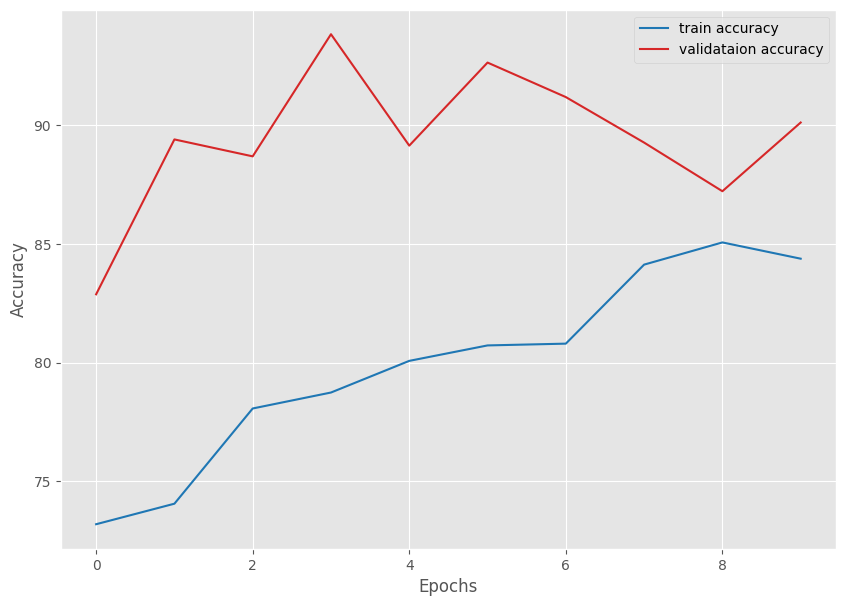

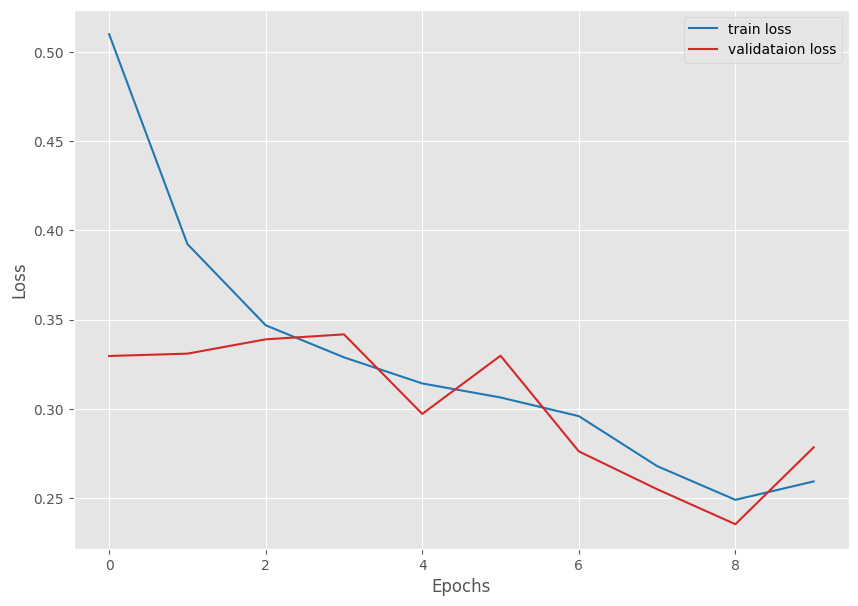

In [ ]:
# Set the seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Assuming you have argparse setup
# If not, you can manually set the values or use the default ones.
# args = argparse.Namespace(epochs=10, lr=0.0001, batch=4, imgsz=512, scheduler=True)

# For Colab, you can manually set the values or use the default ones.
class Args:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.0001
        self.batch = 4
        self.imgsz = 512
        self.scheduler = True

args = Args()

print(args)

if __name__ == '__main__':
    # Create a directory with the model name for outputs.
    out_dir = os.path.join('/content/drive/MyDrive/flood-area-segmentation/', 'outputs')
    out_dir_valid_preds = os.path.join('/content/drive/MyDrive/flood-area-segmentation/', 'outputs', 'valid_preds')
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(out_dir_valid_preds, exist_ok=True)

    # No need to check for GPU availability in Colab
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = prepare_model(num_classes=len(ALL_CLASSES)).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    train_images, train_masks, valid_images, valid_masks = get_images(root_path='/content/drive/MyDrive/flood-area-segmentation')

    classes_to_train = ALL_CLASSES

    train_dataset, valid_dataset = get_dataset(
        train_images,
        train_masks,
        valid_images,
        valid_masks,
        ALL_CLASSES,
        classes_to_train,
        LABEL_COLORS_LIST,
        img_size=args.imgsz
    )

    train_dataloader, valid_dataloader = get_data_loaders(
        train_dataset, valid_dataset, batch_size=args.batch
    )

    # Initialize `SaveBestModel` class.
    save_best_model = SaveBestModel()
    # LR Scheduler.
    scheduler = StepLR(optimizer, step_size=25, gamma=0.1, verbose=True)

    EPOCHS = args.epochs
    train_loss, train_pix_acc = [], []
    valid_loss, valid_pix_acc = [], []
    for epoch in range(EPOCHS):
        print(f"EPOCH: {epoch + 1}")
        train_epoch_loss, train_epoch_pixacc = train(
            model,
            train_dataset,
            train_dataloader,
            device,
            optimizer,
            criterion,
            classes_to_train
        )
        valid_epoch_loss, valid_epoch_pixacc = validate(
            model,
            valid_dataset,
            valid_dataloader,
            device,
            criterion,
            classes_to_train,
            LABEL_COLORS_LIST,
            epoch,
            ALL_CLASSES,
            save_dir=out_dir_valid_preds
        )
        train_loss.append(train_epoch_loss)
        train_pix_acc.append(train_epoch_pixacc.cpu())
        valid_loss.append(valid_epoch_loss)
        valid_pix_acc.append(valid_epoch_pixacc.cpu())

        save_best_model(
            valid_epoch_loss, epoch, model, out_dir
        )

        print(f"Train Epoch Loss: {train_epoch_loss:.4f}, Train Epoch PixAcc: {train_epoch_pixacc:.4f}")
        print(f"Valid Epoch Loss: {valid_epoch_loss:.4f}, Valid Epoch PixAcc: {valid_epoch_pixacc:.4f}")
        if args.scheduler:
            scheduler.step()
        print('-' * 50)

    save_model(EPOCHS, model, optimizer, criterion, out_dir)
    # Save the loss and accuracy plots.
    save_plots(
        train_pix_acc, valid_pix_acc, train_loss, valid_loss, out_dir
    )
    print('TRAINING COMPLETE')
